# weighted mean in transformed space
this is a trash and hacky code I'm still not sure how to clean up

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

from xgcm.autogenerate import generate_grid_ds

from cmip6_preprocessing.postprocessing import match_metrics


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

# load data sets
I changed the saved datasets so that they conserve the `lev_bounds` attribute. I think they are otherwise they same and can be used the same

In [58]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1.nc').sel(y = slice(-80,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE.nc').sel(y = slice(-80,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM.nc').sel(y = slice(-80,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL.nc').sel(y = slice(-80,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM.nc').sel(y = slice(-80,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2.nc').sel(y = slice(-80,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2.nc').sel(y = slice(-80,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2.nc').sel(y = slice(-80,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0.nc').sel(y = slice(-80,-30))

In [72]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## add in `p`, `insitutemp`, `sigma0`, and `PCO2`

In [59]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    
    conversion_PCO2 =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion_PCO2,par2=ds['dissic']*conversion_PCO2,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])

This goes ahead and does the conversions on `fgco2` but still questioning this conversion but it is here for now

In [60]:
for name, ds in dd.items():
    ds['fgco2'] = ds['fgco2']* 3.1536e7 * 83.3 * 12 * -1

# Functions written by Graeme
I have added `areacello` to the functions

In [5]:
# Get some more grid information
# (and correct the lev variable
# so that it is actually between
# lev_bounds)

# Separately calculate dx and dy
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

def get_xgcm(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    xgrid = Grid(ds, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # Get area
    ds['areacello'] = ds['dxC']*ds['dyC']
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'left':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid

def get_xgcm_special(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations
        This is a hacked version to specify "outer" coordinates for y,
        for use with transform method.'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    lat_left = np.append(ds[gridlat+'_left'],ds[gridlat+'_left'].isel(y_left=-1)+1)
    ds = ds.assign_coords({gridlat+'_left':lat_left})
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'}
    }
    xgrid = Grid(ds, coords=coords, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # get area
    ds['areacello'] = ds['dxC']*ds['dyC']
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'outer':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid
# # Get center and outer z coords
# ds['lev'] = ds['lev_bounds'].mean('bnds').values
# ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# # Generate xgcm grid
# ds,xgrid = get_xgcm_special(ds,periodic='X')
# # Create a 3d version of dz
# ds['dz3d']=ds['dz']*xr.ones_like(ds['talk'])

# As a first pass, plotted `PCO2` on `thetao`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

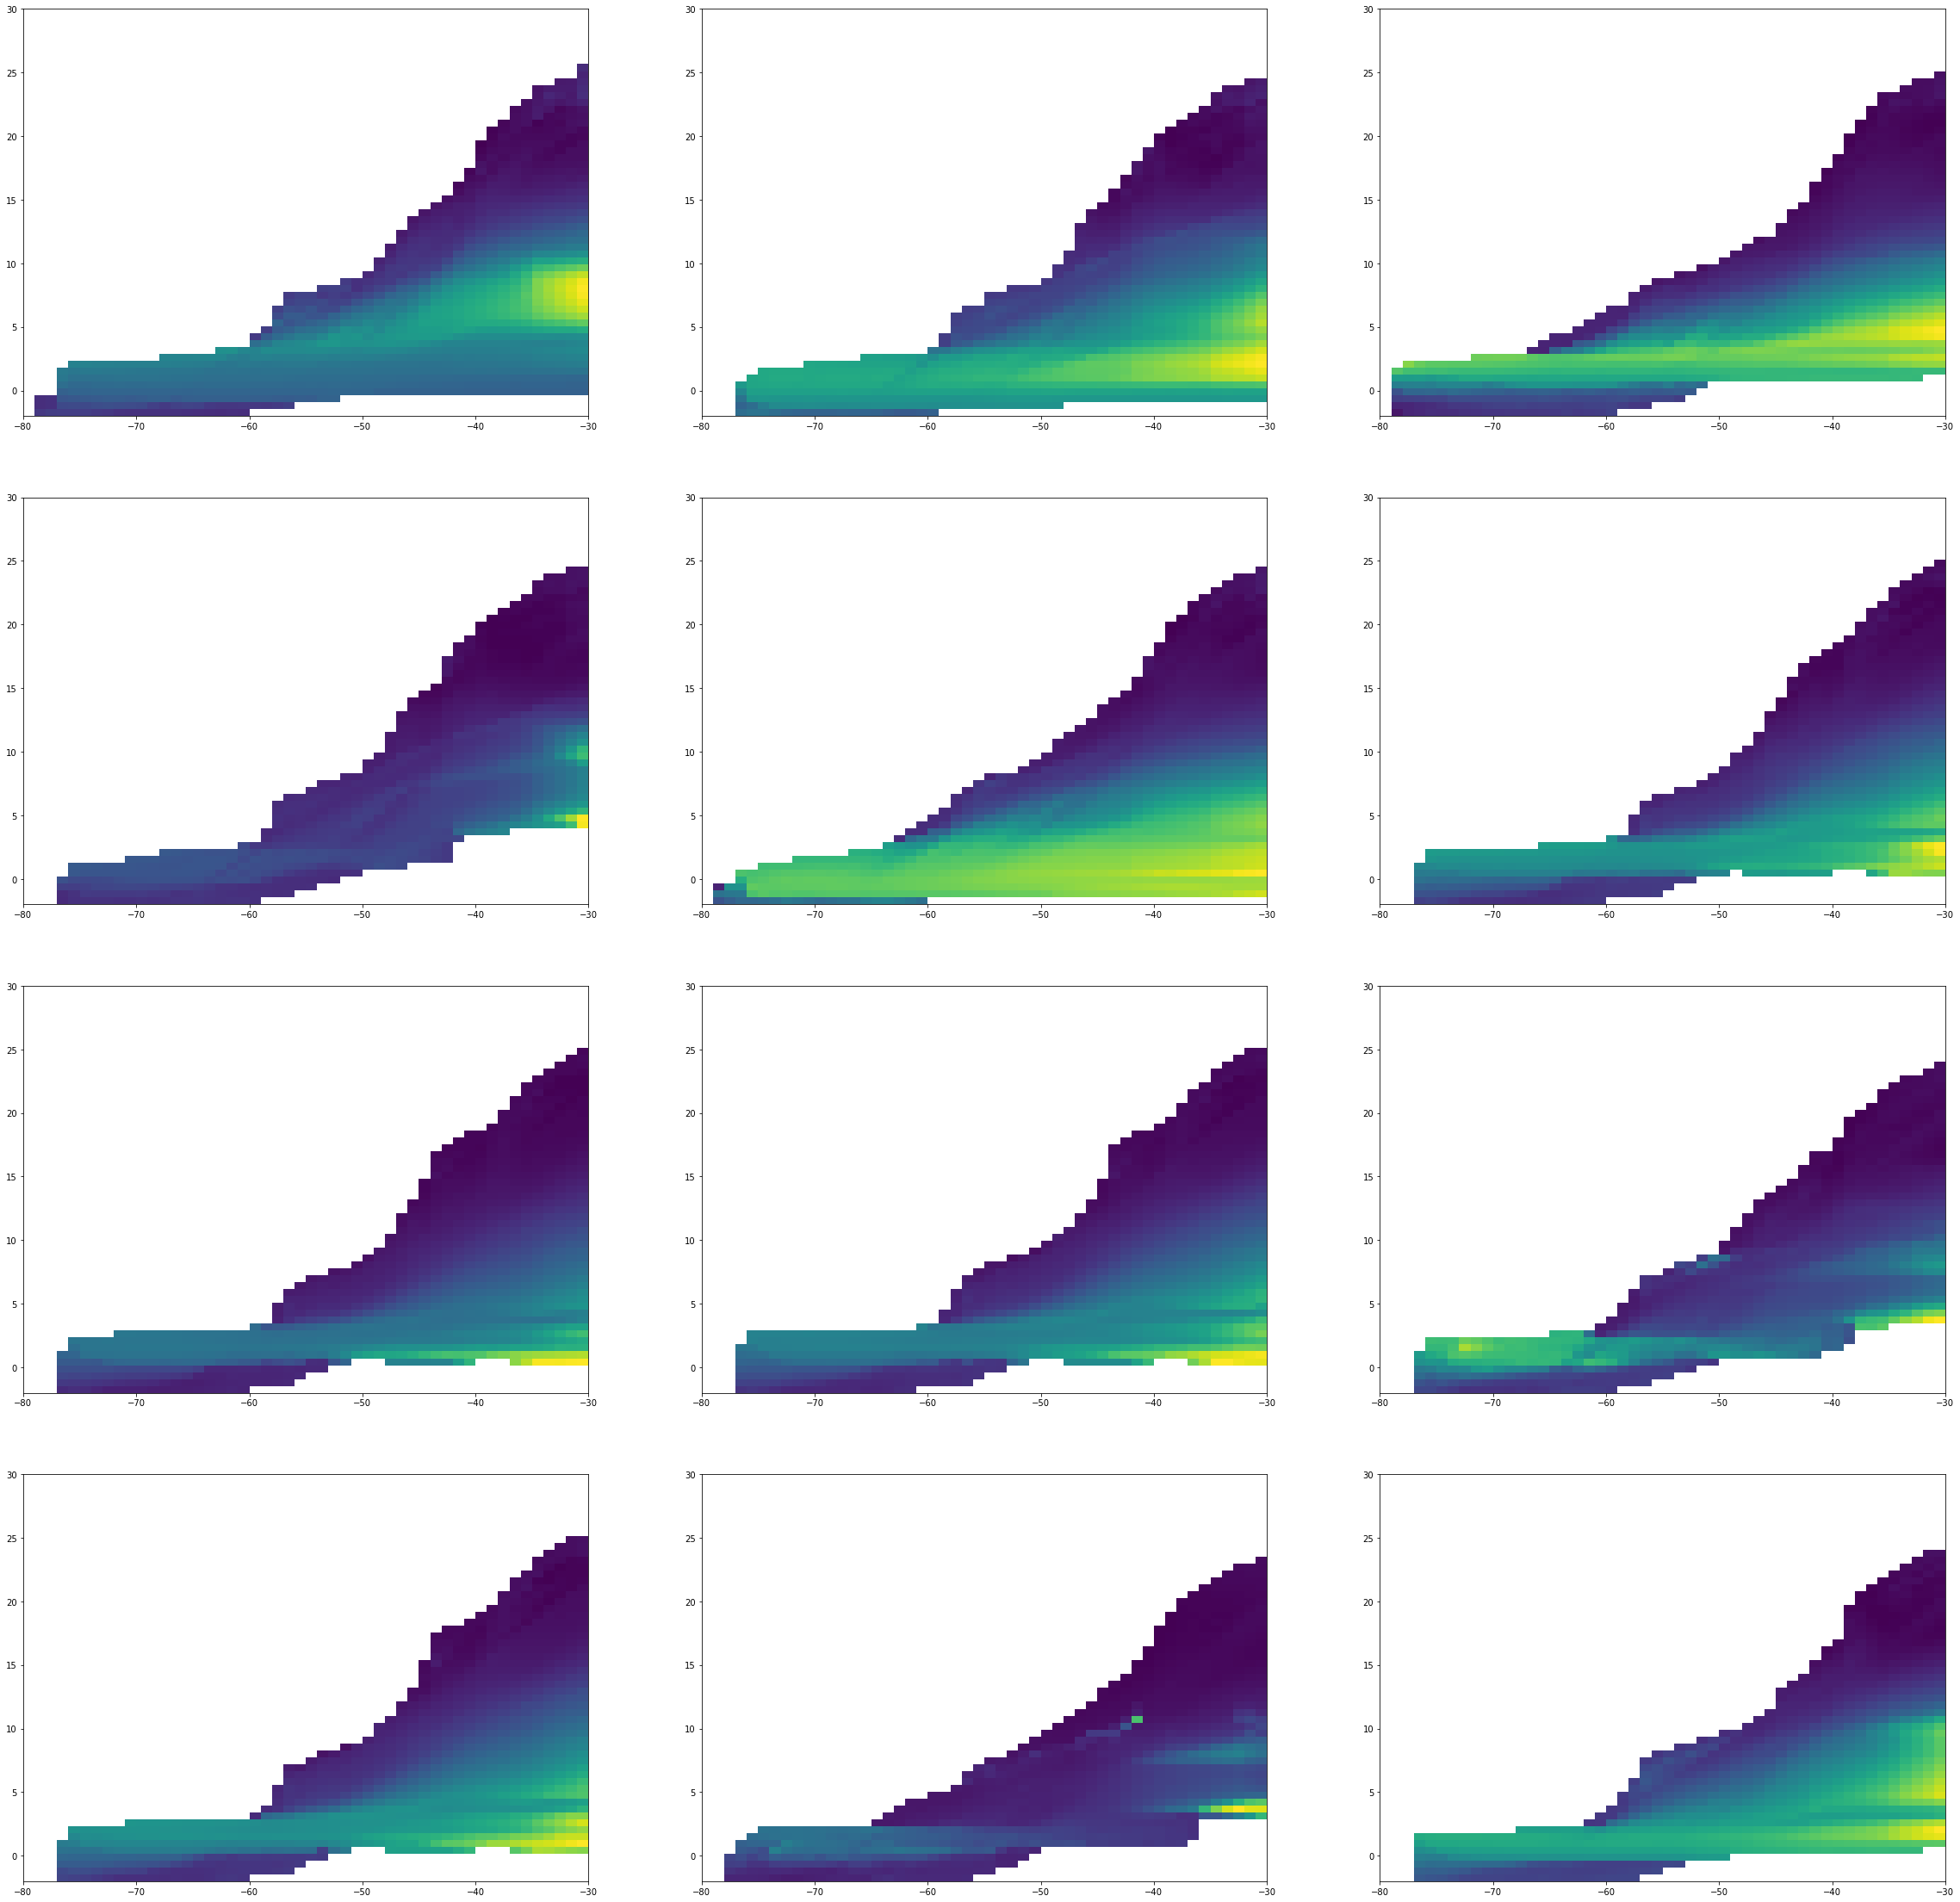

In [6]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40])
target = np.linspace(-2, 30, 60)
ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    
    # Get center and outer z coords
    ds['lev'] = ds['lev_bounds'].mean('bnds').values
    ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    ds,xgrid = get_xgcm_special(ds,periodic='X')
    # Create a 3d version of dz
    ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])
    
    # Interpolate thetao onto lev_outer
    ds['thetao_outer'] = xgrid.interp(ds['thetao'], 'Z', boundary='fill')
    # Need to chunk in lev_outer dimension otherwise transform gets upset
    ds = ds.chunk({'lev_outer':-1})
    # Transform dz
    ds_t = xr.Dataset()
    ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['thetao_outer'])
    # Transform var*dz
    ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['thetao_outer'])

    # Now get dz-weighted mean in x
    ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
    ax.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].thetao_outer, ds_t['PCO2'].transpose('thetao_outer', 'y'))
    ax_idx += 1

# `PCO2` on `sigma0`
Stuff starts looking funky here, particularly for CanESM5 and GFDL models

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

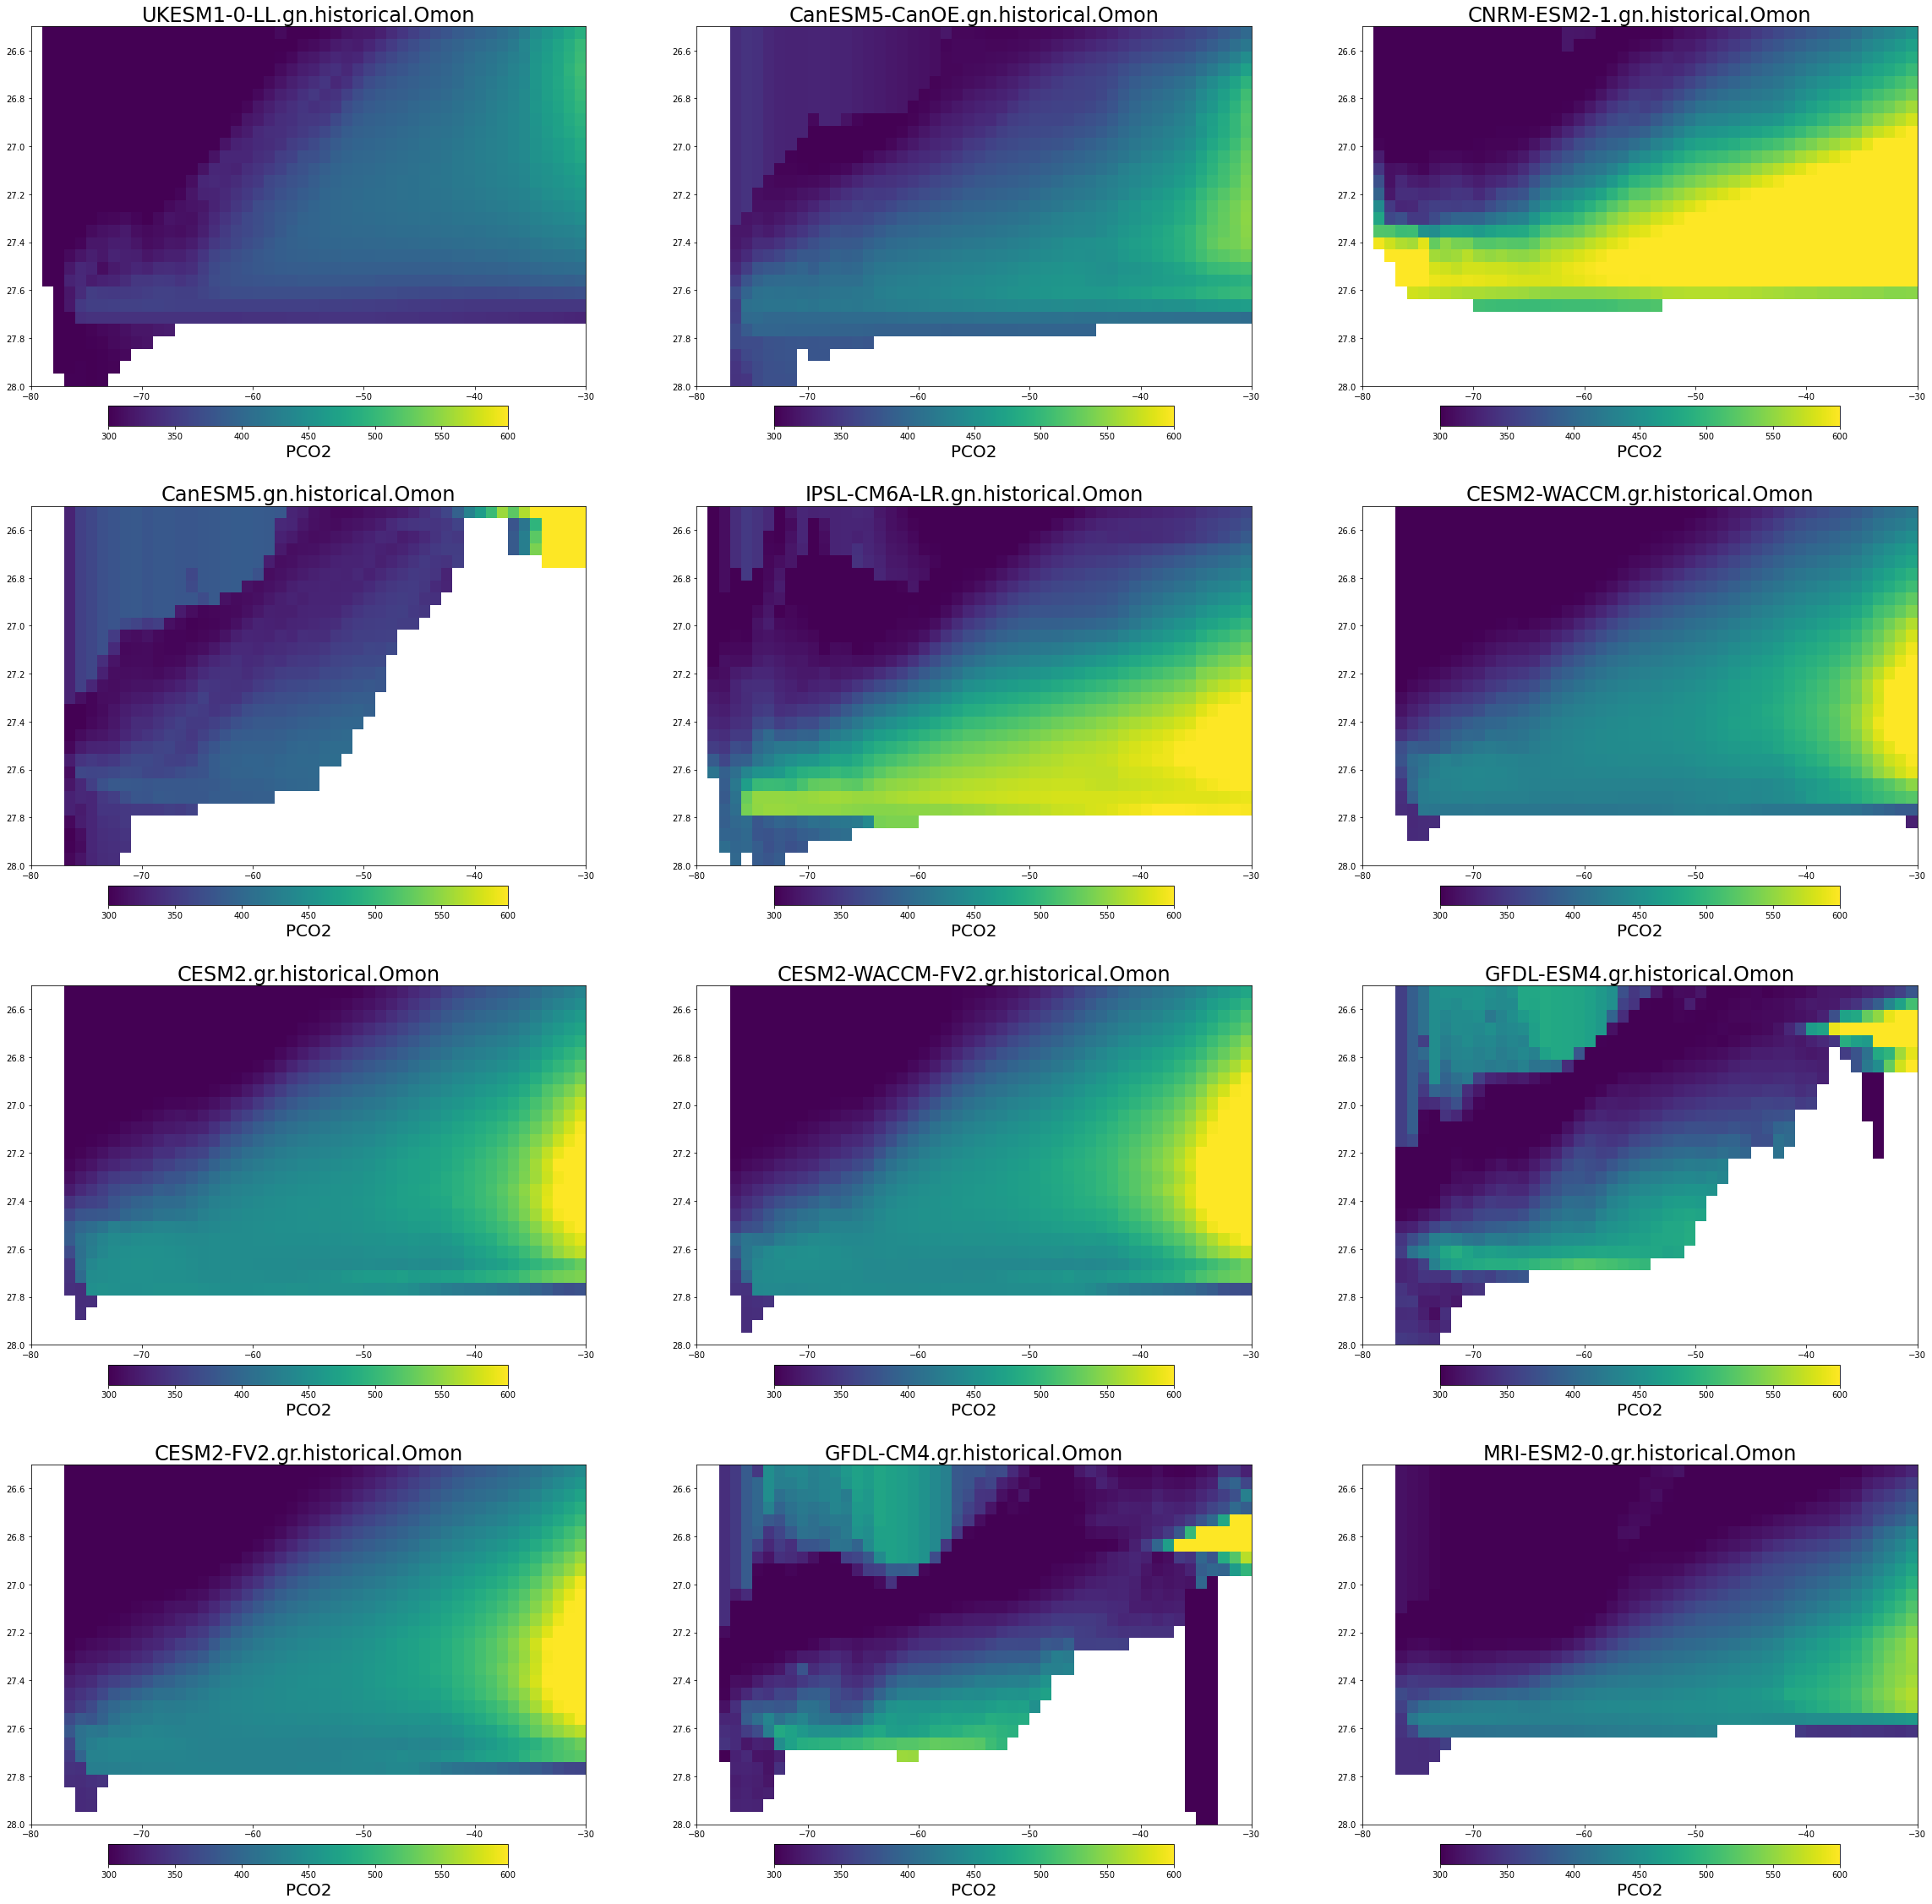

In [35]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40])
target = np.linspace(26.5, 28, 30)
ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    
    # Get center and outer z coords
    ds['lev'] = ds['lev_bounds'].mean('bnds').values
    ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    ds,xgrid = get_xgcm_special(ds,periodic='X')
    # Create a 3d version of dz
    ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])
    
    # Interpolate thetao onto lev_outer
    ds['sigma0_outer'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
    # Need to chunk in lev_outer dimension otherwise transform gets upset
    ds = ds.chunk({'lev_outer':-1})
    # Transform dz
    ds_t = xr.Dataset()
    ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'])
    # Transform var*dz
    ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'])

    # Now get dz-weighted mean in x
    ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
    im = ax.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer, ds_t['PCO2'].transpose('sigma0_outer', 'y'), vmin = 300, vmax = 600)
    ax.invert_yaxis()
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
    cbar.set_label('PCO2', fontsize = 20)
    ax.set_title(name, fontsize = 24)
    ax_idx += 1

Some of the models (MRI, CESM2, CNRM, UKESM1) look more or less the same. The major difference is that there is now a large chunk of less dense water with little to no PCO2. I'm still not sure how to conceptualize this. I think I *want* to think that since this chunk of less dense water takes up a big portion of the plot, there is actually a lot of this water, but I'm not sure I can say that from this plot. 

Some of the other models looks WILD! Namely, the CanESM5 and GFDL models. They have a less dense water mass high in PCO2 that (as we can see below) generally corresponds with CO2 uptake. My best guess what this is right now is that it's a subducting water mass taking up CO2 from the atmosphere and transporting CO2 into the interior ocean. Could I be wrong? Most likely, yes. Actually, I know I'm wrong, but I have no other guesses right now. If the unthinkable happens and I'm actually onto something, I think overturning might clear things up.

# `fgco2` on sigma0
this is an old cell block that i haven't rerun cause my code is shit and overwrites everything right now, so conversions and signs might be weird but the point is that it plots *something*

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

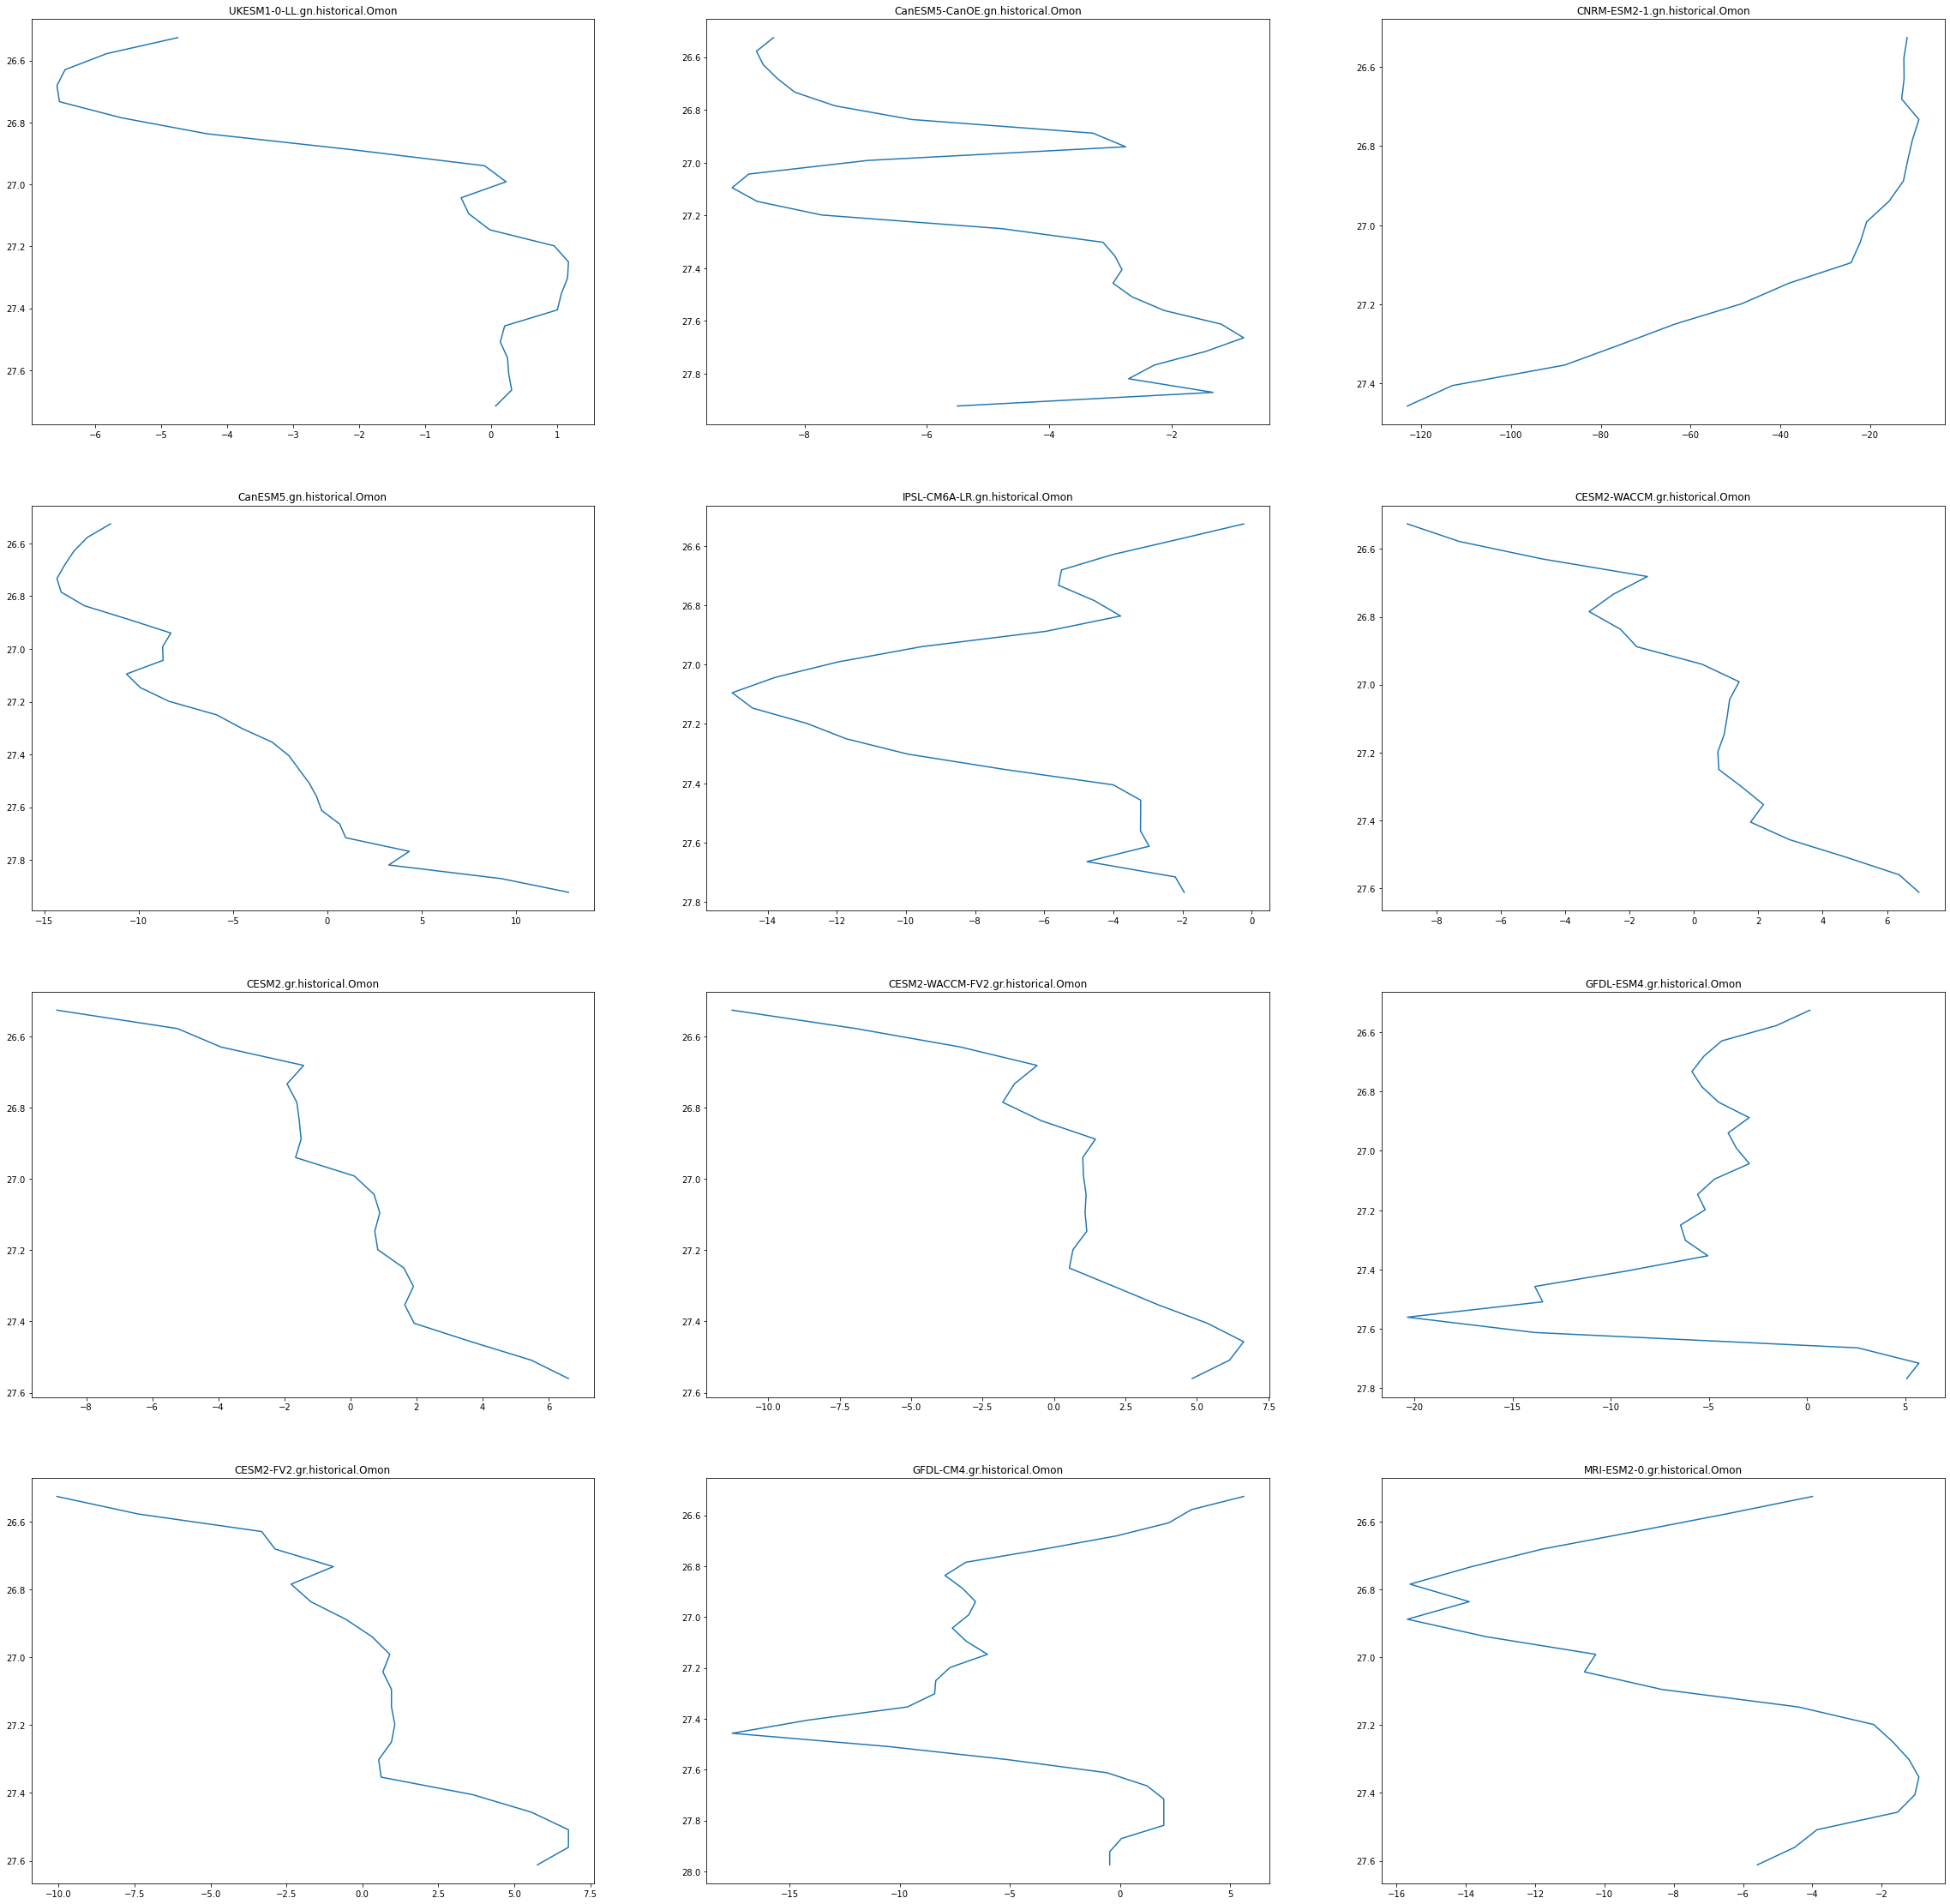

In [37]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40])
target = np.linspace(26.5, 28, 30)
ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]

    
    # Get center and outer z coords
    ds['lev'] = ds['lev_bounds'].mean('bnds').values
    ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    ds,xgrid = get_xgcm_special(ds,periodic='X')
    
    # Interpolate thetao onto y_left
    ds['sigma0_outer'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
    # Need to chunk in lev_outer dimension otherwise transform gets upset
    ds = ds.chunk({'y_left':-1})
    # Transform areacello
    ds_t = xr.Dataset()
    ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'].isel(lev=0))
    # Transform var * areacello
    ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'].isel(lev=0))

    # Now get dz-weighted mean in x
    ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
    ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer)
    ax.set_title(name)
    ax.invert_yaxis()
    ax_idx += 1


# Now plotting things together
Admittedly it is very hacky. I'm constantly overwriting `ds_t` because I'm not sure what I ideally want in that. I'm also not sure how to treat `xgrid.interp('Z')` and `xgrid.interp('Y')` and have them happen at the same time???

ugh also now realizing that the way `ds_t` is set up (meaning it doesn't have model name keys) means I can't conveniently throw in `**model_kwargs`. So I need to figure out how to get like a "master" `ds_t` that has the model key and contains all the info I need and isn't constantly overwritten


## CESM2-FV2
`color = '#024c8f'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

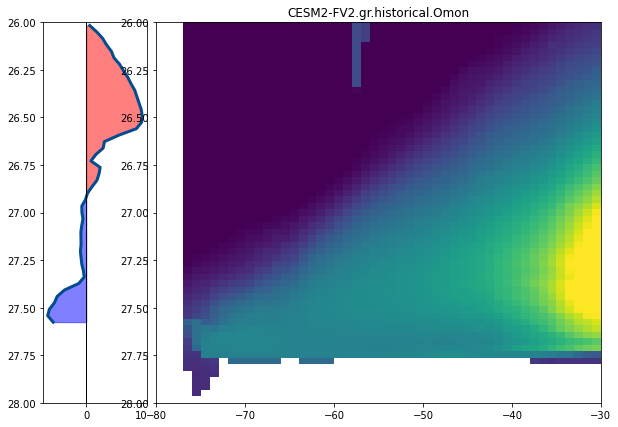

In [83]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['CESM2-FV2.gr.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#024c8f')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




## CNRM-ESM2-1
`color = '#cc0000'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

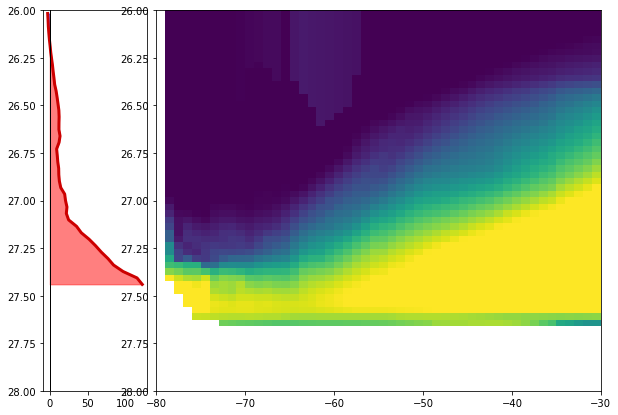

In [82]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['CNRM-ESM2-1.gn.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#cc0000')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




No CO2 uptake in this density range????

## CanESM5-CanOE
`color = '#a1a1a1'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

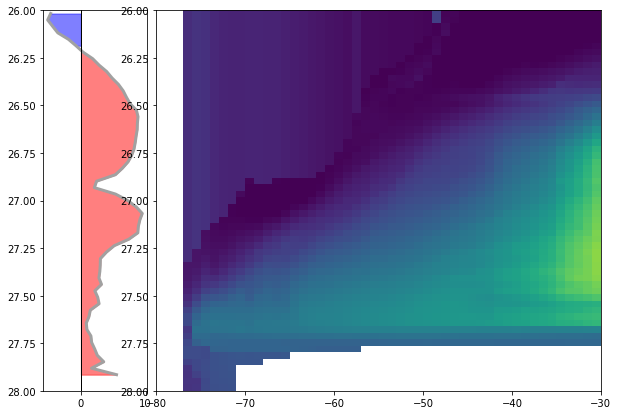

In [81]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['CanESM5-CanOE.gn.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#a1a1a1')
ax.set_ylim([26, 28])
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.invert_yaxis()




recalling that CanESM5 models have high total outgassing, something makes sense about how much CO2 is outgassed in this persepctive. TBD what makes sense to me but *something*

## GFDL-ESM4
`color = '#674ea7'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

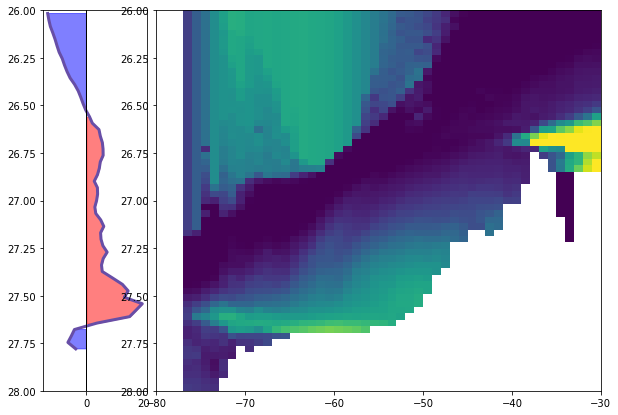

In [80]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['GFDL-ESM4.gr.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#674ea7')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




weird.......

## IPSL-CM6A-LR
`color = '#f1c232'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

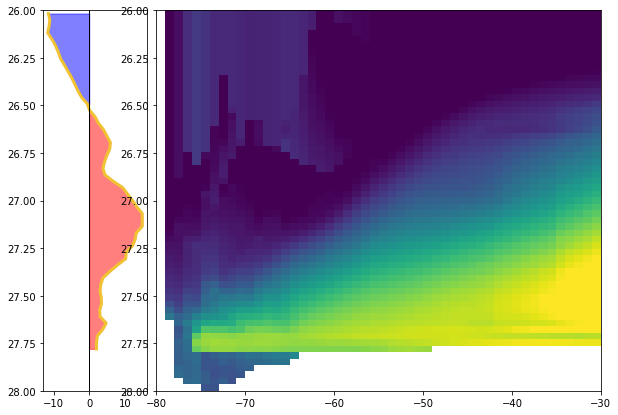

In [79]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['IPSL-CM6A-LR.gn.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#f1c232')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




I can make this one make sense in my head

## GFDL-CM4
`color = '#800080'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

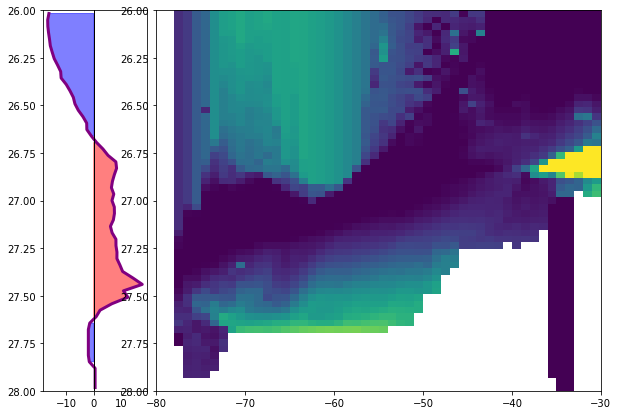

In [78]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['GFDL-CM4.gr.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#800080')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




WACKY!

## MRI-ESM2-0
`color = '#ff80ed'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

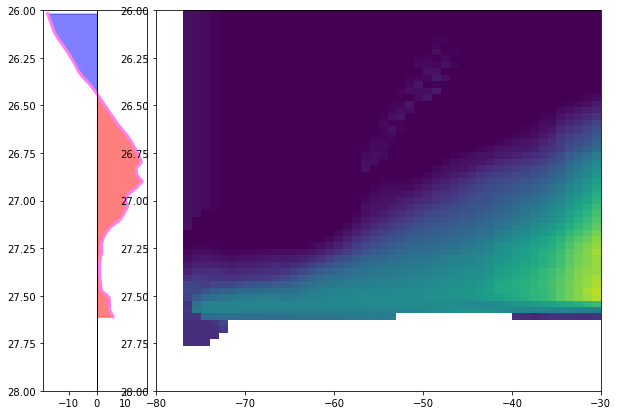

In [77]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['MRI-ESM2-0.gr.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#ff80ed')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




this one might also make sense maybe

## UKESM1-0-LL
`color = '#8f5904'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

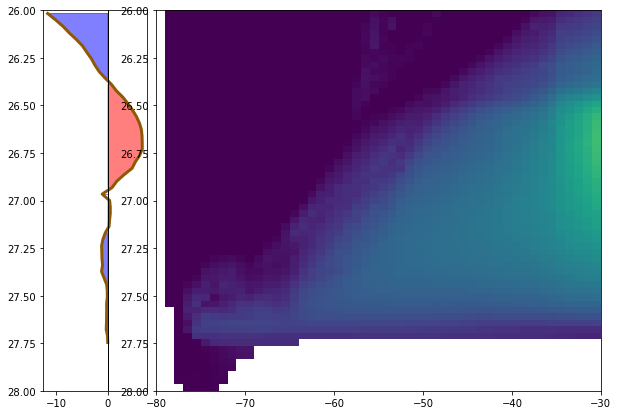

In [76]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['UKESM1-0-LL.gn.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#8f5904')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




## CanESM5
`color = '#ff8200'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

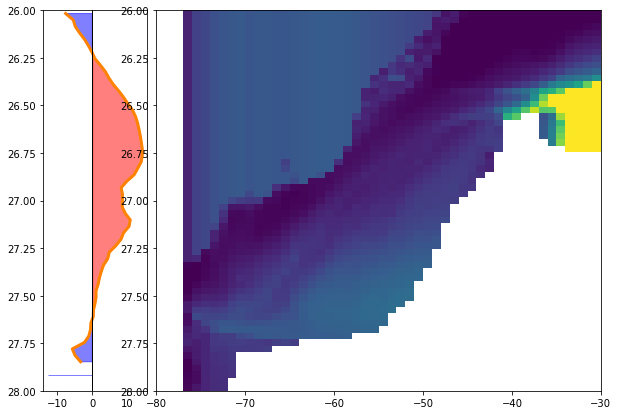

In [75]:
fig = plt.figure(figsize=(10, 7)) 
ax = plt.subplot2grid((5,10), (0, 0), rowspan = 5, colspan = 2)
ax2 = plt.subplot2grid((5,10), (0, 2), colspan = 10, rowspan = 5)

ds = dd['CanESM5.gn.historical.Omon']

target = np.linspace(26, 28, 60)

# Get center and outer z coords
ds['lev'] = ds['lev_bounds'].mean('bnds').values
ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# Generate xgcm grid
ds,xgrid = get_xgcm_special(ds,periodic='X')
# Create a 3d version of dz
ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

# Interpolate thetao onto lev_outer
ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
# Need to chunk in lev_outer dimension otherwise transform gets upset
ds = ds.chunk({'lev_outer':-1})


# Transform dz
ds_t = xr.Dataset()
ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
# Transform var*dz
ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

# Now get dz-weighted mean in x
ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
ax2.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer3d, ds_t['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
ax2.invert_yaxis()
# ax2.set_title('CESM2-FV2.gr.historical.Omon')

ds = ds.chunk({'y_left':-1})
# ds_t = xr.Dataset()
ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
# Transform var * areacello
ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

# Now get dz-weighted mean in x
ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer2d, lw = 3, color = '#ff8200')
ax.axvline(x=0, color = 'k', lw = 1)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']>0),0,color = 'r', alpha = 0.5)
ax.fill_betweenx(ds_t['fgco2'].sigma0_outer2d,ds_t['fgco2'].where(ds_t['fgco2']<0),0,color = 'b', alpha = 0.5)
ax.set_ylim([26, 28])
ax.invert_yaxis()




So I'm still left wondering what water masses are represented here. I also have a tiny voice in the back of my head saying that something might be weird because I'm using `sigma0` (as opposed to neutral density or density referenced to some other depth like 1000 meters or whatever).

At some point in this process of messing around, I did transform onto a larger range of densities (like 0 to 30) and that didn't provide any other relevant information